### Imports


In [1]:
import transformers, datasets
import numpy as np
from datasets import load_dataset
transformers.__version__, datasets.__version__

('4.39.3', '2.18.0')

### WandB for logging performance metrics


In [2]:
import os 
os.environ['WANDB_API_KEY'] = '##########################'

### Dataset

In [3]:
raw_datasets = datasets.load_dataset("glue", "rte")

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [4]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

In [5]:
import pandas as pd
pd.Series(raw_datasets["validation"]["label"]).value_counts()

0    146
1    131
Name: count, dtype: int64

In [6]:
raw_datasets['train'].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['entailment', 'not_entailment'], id=None),
 'idx': Value(dtype='int32', id=None)}

### Model and Tokenizer

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig # Autoconfig 

#checkpoint = "bert-base-uncased"
checkpoint = "distilbert-base-uncased"

config = AutoConfig.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels= 2)  

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
!pip install torchinfo
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           1,538
├─Dropout: 1-4                                          --
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0

In [10]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence1'],batch['sentence2'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)

tokenized_datasets

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
})

### Training Arguments

In [35]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    'training_dir_2',
    num_train_epochs = 5,
    learning_rate = 1e-5,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_steps = 0.05,
    logging_dir="./logs",
    save_steps = 0.05,
    load_best_model_at_end = True,
    run_name= "glue-rte-1",
    fp16 = False,
    save_total_limit = 5, 
    report_to="wandb")

### Trainer and performance metrics 

In [36]:
from transformers import Trainer
import torch
lang = 'eng'
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, log_loss, f1_score, confusion_matrix
from torch.nn import CrossEntropyLoss
def compute_metrics(pred):
    global num_labels
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    logits = torch.tensor(pred.predictions)
    labels = torch.tensor(labels)
    return {
        'accuracy@'+lang: acc,
        'f1@'+lang: f1,
        'precision@'+lang: precision,
        'recall@'+lang: recall,
     }



In [37]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Training

In [38]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy@eng,F1@eng,Precision@eng,Recall@eng
10,0.697500,0.691493,0.516245,0.457720,0.571835,0.535606
20,0.696200,0.689402,0.577617,0.569516,0.596979,0.586767
30,0.692400,0.687532,0.534296,0.470724,0.528722,0.517045
40,0.695100,0.687163,0.545126,0.461788,0.554617,0.525358
50,0.686700,0.686649,0.570397,0.555928,0.568543,0.562271
60,0.690700,0.686931,0.537906,0.520346,0.561461,0.549880
70,0.688800,0.685325,0.584838,0.582202,0.594910,0.590871
80,0.683900,0.683526,0.617329,0.616724,0.616719,0.616987
90,0.680500,0.682572,0.584838,0.583448,0.592083,0.589695
100,0.677800,0.681633,0.581227,0.578807,0.590637,0.587054


TrainOutput(global_step=195, training_loss=0.6777672963264662, metrics={'train_runtime': 161.3034, 'train_samples_per_second': 77.184, 'train_steps_per_second': 1.209, 'total_flos': 636610893049608.0, 'train_loss': 0.6777672963264662, 'epoch': 5.0})

### Inference

In [39]:
!ls "/kaggle/working/training_dir_2/"

checkpoint-150	checkpoint-160	checkpoint-170	checkpoint-180	checkpoint-190


In [42]:
from transformers import pipeline

savedmodel = pipeline('text-classification',
                      model='training_dir_2/checkpoint-190',
                      device='cuda')
config = AutoConfig.from_pretrained("training_dir_2/checkpoint-190")

In [43]:
inputs = [
    {"text": sentence1, "text_pair": sentence2}
    for sentence1, sentence2 in zip(raw_datasets['validation']['sentence1'], raw_datasets['validation']['sentence2'])
]

test_pred = savedmodel(inputs)


In [44]:
test_pred[:2]

[{'label': 'LABEL_0', 'score': 0.5469880104064941},
 {'label': 'LABEL_1', 'score': 0.5295218825340271}]

In [45]:
def get_label(d):
    return int(d['label'].split('_')[1])

test_pred = [get_label(d) for d in test_pred]

In [46]:
print("acc:", accuracy_score(raw_datasets['validation']['label'], test_pred))
print("f1:", f1_score(raw_datasets['validation']['label'], test_pred, average='macro'))

acc: 0.6101083032490975
f1: 0.6098591549295775


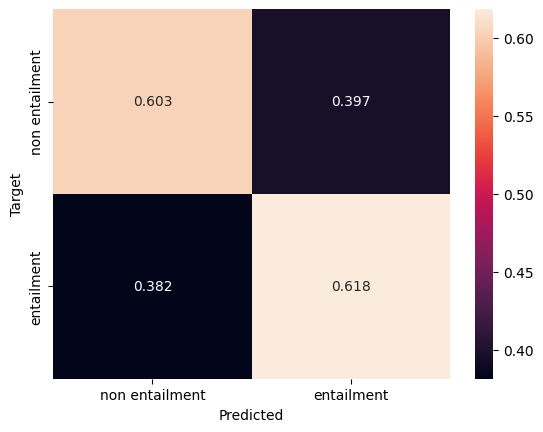

In [47]:
import seaborn as sns 
import matplotlib.pyplot as plt

cm = confusion_matrix(tokenized_datasets['validation']['label'], test_pred, normalize='true')

ax= sns.heatmap(cm, annot= True, fmt = ".3f", xticklabels = ["non entailment","entailment"],
           yticklabels = ["non entailment","entailment"], )

ax.set(xlabel="Predicted", ylabel="Target")
plt.show()